### 데이터 로드 및 전처리

- CIFAR10 데이터셋을 로드하고, 훈련 데이터셋에서 20%를 검증 데이터셋으로 분리한다.

In [1]:
# 필요 라이브러리 불러오기
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers, utils
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import callbacks, optimizers

In [2]:
# cifar10 데이터셋을 로드하고, 훈련 데이터셋에서 20%를 검증 데이터셋으로 분리한다.
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full,
                                                  test_size=0.2,
                                                  random_state=123)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력한다.
print("전체 학습 데이터: {} 레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("학습 데이터: {} 레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(x_val.shape, y_val.shape))
print("테스트 데이터: {} 레이블: {}".format(x_test.shape, y_test.shape))

전체 학습 데이터: (50000, 32, 32, 3) 레이블: (50000, 1)
학습 데이터: (40000, 32, 32, 3) 레이블: (40000, 1)
검증 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)
테스트 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)


- class_name 변수를 만들어 cifar10의 분류에 해당하는 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'를 담는다.

In [3]:
# cifar10의 분류에 해당하는 'airplane', 'automobile', 'bird', 'cat', 'deer', 
# 'dog', 'frog', 'horse', 'ship', 'truck'를 class_name으로 정의합니다.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

- 데이터 중 샘플 하나를 시각화해보고, 데이터의 형태를 확인해본다.

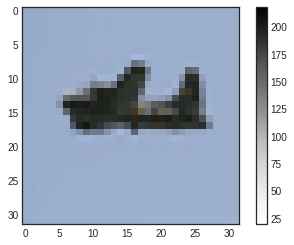

In [5]:
# 훈련 데이터의 0번째인 x_train[0]를 이미지로 시각화한다.
plt.style.use('seaborn-white')

plt.figure()
plt.imshow(x_train[3])
plt.colorbar()
plt.show()

In [6]:
# 훈련, 검증, 테스트 데이터의 형태(shape)을 출력한다.
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


- 데이터의 형태를 변형하여 모델이 잘 학습할 수 있게끔 해준다.

In [7]:
# 훈련, 검증, 테스트 데이터의 형태(shape)을 32 * 32 * 3 = 3072로 변형 후 확인한다.
x_train = x_train.reshape(-1, 32 * 32 * 3)
x_val = x_val.reshape(-1, 32 * 32 * 3)
x_test = x_test.reshape(-1, 32 * 32 * 3)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 3072)
(10000, 3072)
(10000, 3072)


In [8]:
# 훈련, 검증, 테스트 데이터를 255로 나누어 0~1 사이의 값으로 변환한다.
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

### 모델 구성 및 컴파일

- BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 10개의 이미지를 분류하는 딥러닝 모델을 구성한다.

In [9]:
# BatchNormalization과 Dropout을 적용하여 빠른 학습과 과대적합을 방지하고,
# 10개의 이미지를 분류하는 딥러닝 모델을 구성한다.
model = models.Sequential()
model.add(layers.Input(shape=(3072, )))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5

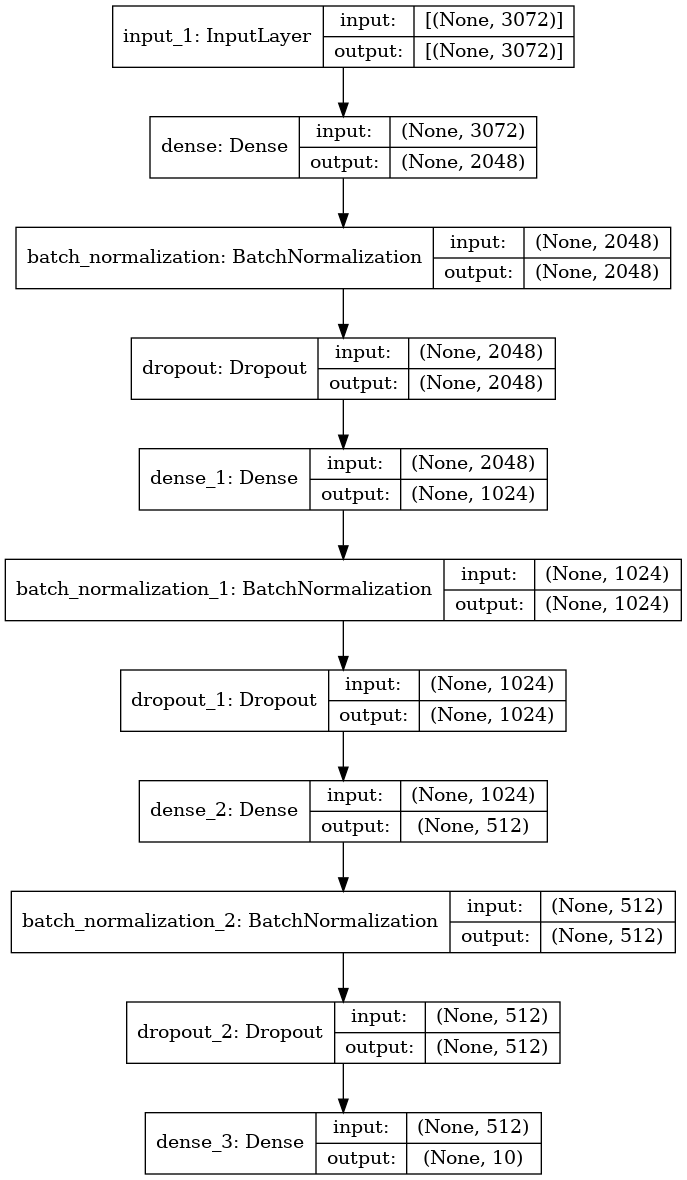

In [11]:
# Layers 시각화하기
utils.plot_model(model, show_shapes=True)

### 모델 학습

- ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행한다.

In [12]:
# ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('CIFAR10_model.h5', save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=50, monitor='val_loss',
                                            restore_best_weights=True)

history = model.fit(x_train, y_train,
                    epochs=800,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/800
79/79 [==============================] - 4s 27ms/step - loss: 2.3399 - accuracy: 0.2432 - val_loss: 4.2099 - val_accuracy: 0.2080
Epoch 2/800
79/79 [==============================] - 1s 11ms/step - loss: 1.8608 - accuracy: 0.3311 - val_loss: 1.9060 - val_accuracy: 0.3293
Epoch 3/800
79/79 [==============================] - 1s 12ms/step - loss: 1.7782 - accuracy: 0.3637 - val_loss: 1.7658 - val_accuracy: 0.3514
Epoch 4/800
79/79 [==============================] - 1s 12ms/step - loss: 1.7073 - accuracy: 0.3884 - val_loss: 1.8284 - val_accuracy: 0.3412
Epoch 5/800
79/79 [==============================] - 1s 11ms/step - loss: 1.6533 - accuracy: 0.4070 - val_loss: 1.6658 - val_accuracy: 0.4060
Epoch 6/800
79/79 [==============================] - 1s 11ms/step - loss: 1.6109 - accuracy: 0.4207 - val_loss: 1.8365 - val_accuracy: 0.3409
Epoch 7/800
79/79 [==============================] - 1s 11ms/step - loss: 1.5788 - accuracy: 0.4329 - val_loss: 1.6816 - val_accuracy: 0.4010
Epoch 

- 학습 히스토리의 loss, val_loss, accuracy, val_accuracy를 차트로 시각화한다.

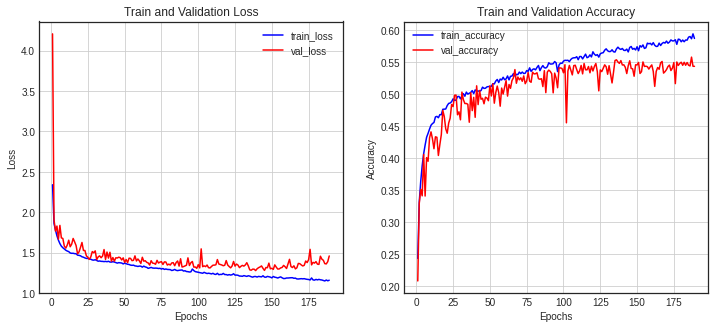

In [13]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화한다.
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

### 모델 평가 및 예측

- 테스트 데이터셋을 이용해 모델을 평가한다.

In [14]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.2670 - accuracy: 0.5508


[1.2670124769210815, 0.5508000254631042]